In [1]:
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import numpy as np
import torch

import adsolver
import utils

%load_ext autoreload
%autoreload 2


In [2]:
def ax_pos_inch_to_absolute(fig_size, ax_pos_inch):
    ax_pos_absolute = []
    ax_pos_absolute.append(ax_pos_inch[0]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[1]/fig_size[1])
    ax_pos_absolute.append(ax_pos_inch[2]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[3]/fig_size[1])
    
    return ax_pos_absolute

In [3]:
# In some cases I found it necessary to use double precision
torch.set_default_dtype(torch.float64)

# Demonstration

In [4]:
# instantiating a solver using the default values, except for t_max which is set up for a 96 year long run
solver = adsolver.ADSolver(t_max=360*96*86400)

### The following cell runs the solver -- takes about 20 sec for 96 years.

In [6]:
u = solver.solve(source_func=utils.make_source_func(solver)[0])

In [7]:
# estimating QBO amplitudes and period
spinup_time = 12*360*86400

amp25 = utils.estimate_amplitude(solver.time, solver.z, u, height=25e3, spinup=spinup_time)
amp20 = utils.estimate_amplitude(solver.time, solver.z, u, height=20e3, spinup=spinup_time)
tau25 = utils.estimate_period(solver.time, solver.z, u, height=25e3, spinup=spinup_time)  # in units of days, assuming sample rate of 1 day -- devide by 30 to get period in months for a 360 day year

### Plotting the solution

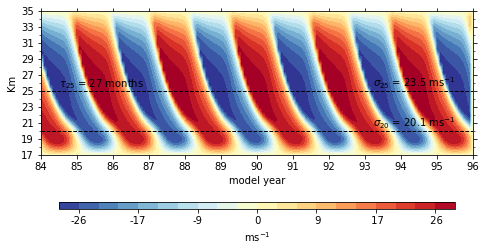

In [8]:
fig_size = (06.90, 02.20+01.50)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

cmin = -np.max(np.abs(u.numpy()))
cmax = np.max(np.abs(u.numpy()))

xmin = 84.
xmax = 96.
ymin = 17.
ymax = 35.

ax[0].set_xlim(left=84.)
ax[0].set_xlim(right=96.)
ax[0].set_ylim(bottom=17.)
ax[0].set_ylim(top=35.)

h = []
    
h.append(ax[0].contourf(solver.time[::30]/86400/360, solver.z[:]/1000, u.numpy()[::30, :].T,
                           21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

ax[0].axhline(25., xmin=0, xmax=1, color='black', linestyle='dashed', linewidth=1.)
ax[0].axhline(20., xmin=0, xmax=1, color='black', linestyle='dashed', linewidth=1.)

ax[0].set_ylabel('Km', fontsize=10)

ax[0].set_xlabel('model year', fontsize=10)

xticks_list = np.arange(xmin, xmax+1, 1)
ax[0].set_xticks(xticks_list)

yticks_list = np.arange(ymin, ymax+2, 2)
ax[0].set_yticks(yticks_list)

xticklabels_list = list(xticks_list)
xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
ax[0].set_xticklabels(xticklabels_list, fontsize=10)

ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
ax[0].tick_params(which='both', labelbottom=True)

ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r' $\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r' $\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %tau25 + ' months',
              horizontalalignment='left', verticalalignment='bottom', color='black')

# # colorbars
cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
                      boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
                      label=r'$\mathrm{m s^{-1}}$')


# Individual terms plot

In [9]:
sfunc, gfunc, Ffunc = utils.make_source_func(solver)
g0 = torch.zeros_like(u)
g1 = torch.zeros_like(u)
F0 = torch.zeros_like(u)
F1 = torch.zeros_like(u)
dF0 = torch.zeros_like(u)
dF1 = torch.zeros_like(u)
S = torch.zeros_like(u)
rhs = torch.zeros_like(u)
diffu = torch.zeros_like(u)

for i in range(solver.time.shape[0]):
    g0[i, :] = gfunc(32, 1 * 2 * np.pi / 4e7, u[i, :])
    g1[i, :] = gfunc(-32, 1 * 2 * np.pi / 4e7, u[i, :])
    F0[i, :] = Ffunc(6e-4 / 0.1006, g0[i, :]) * 0.1006
    F1[i, :] = Ffunc(-6e-4 / 0.1006, g1[i, :]) * 0.1006
    dF0[i, :] = torch.matmul(solver.D1, F0[i, :]) / utils.get_rho(solver.z)
    dF1[i, :] = torch.matmul(solver.D1, F1[i, :]) / utils.get_rho(solver.z)
    S[i, :] = sfunc(u[i, :])
    rhs[i, :] = (-solver.w * torch.matmul(solver.D1, u[i, :]) + solver.kappa * torch.matmul(solver.D2, u[i, :]) - S[i, :])
    diffu[i, :] = solver.kappa * torch.matmul(solver.D2, u[i, :])


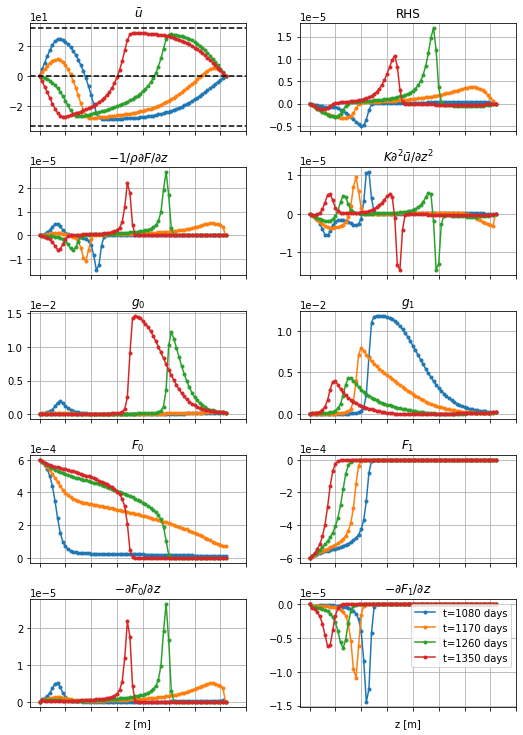

In [10]:
fig_size = (08.00, 11.25)  #02.20+01.50)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 09.25, 03.00, 01.50])))
ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 07.25, 03.00, 01.50])))
ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 05.25, 03.00, 01.50])))
ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 03.25, 03.00, 01.50])))
ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 03.00, 01.50])))
ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [04.50, 09.25, 03.00, 01.50])))
ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [04.50, 07.25, 03.00, 01.50])))
ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [04.50, 05.25, 03.00, 01.50])))
ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [04.50, 03.25, 03.00, 01.50])))
ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [04.50, 01.25, 03.00, 01.50])))


times = [ 360*3 + 90*i for i in range(4) ]

x_ticks_list = np.arange(17e3, 37.5e3, 2500)

ax[0].plot(solver.z[:], u[times, :].T, marker='.')
ax[0].axhline(0., xmin=0, xmax=1, color='black', linestyle='dashed')
ax[0].axhline(32., xmin=0, xmax=1, color='black', linestyle='dashed')
ax[0].axhline(-33., xmin=0, xmax=1, color='black', linestyle='dashed')
ax[0].set_title(r'$\bar{u}$')
ax[0].xaxis.set_ticklabels([])


ax[1].plot(solver.z[:], -S[times, :].T, marker='.')
ax[1].set_title(r'$- 1 / \rho \partial F / \partial z$')
ax[1].xaxis.set_ticklabels([])

ax[2].plot(solver.z[:], g0[times, :].T, marker='.')
ax[2].set_title(r'$g_0$')
ax[2].xaxis.set_ticklabels([])

ax[3].plot(solver.z[:], F0[times, :].T, marker='.')
ax[3].set_title(r'$F_0$')
ax[3].xaxis.set_ticklabels([])

ax[4].plot(solver.z[:], -dF0[times, :].T, marker='.')
ax[4].set_title(r'$- \partial F_0 / \partial z$')
ax[4].xaxis.set_ticklabels([])
ax[4].set_xlabel('z [m]', fontsize=10)

ax[5].plot(solver.z[:], rhs[times, :].T, marker='.')
ax[5].set_title('RHS')
ax[5].xaxis.set_ticklabels([])

ax[6].plot(solver.z[:], diffu[times, :].T, marker='.')
ax[6].set_title(r'$K \partial^2 \bar{u} / \partial z^2$')
ax[6].xaxis.set_ticklabels([])

ax[7].plot(solver.z[:], g1[times, :].T, marker='.')
ax[7].set_title(r'$g_1$')
ax[7].xaxis.set_ticklabels([])

ax[8].plot(solver.z[:], F1[times, :].T, marker='.')
ax[8].set_title(r'$F_1$')
ax[8].xaxis.set_ticklabels([])

ax[9].plot(solver.z[:], -dF1[times, :].T, marker='.', label=['t=' + str(step) + ' days' for step in times])
ax[9].set_title(r'$- \partial F_1 / \partial z$')
ax[9].xaxis.set_ticklabels([])
ax[9].set_xlabel('z [m]', fontsize=10)
ax[9].legend()

for i in range(10):
    ax[i].set_xticks(x_ticks_list)
    ax[i].grid()
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))


# "Calibration"

We now use backpropagation to demonstrate a calibration problem where we seek to tune both the wave amplitudes and phase speeds to produce an oscillation with high-level amplitude of $23.5$ m s$^{-1}$, low-level amplitude of $21$ m s$^{-1}$, and a period of 28 months (the amplitudes are rather arbitrary, but the period corresponds to observations and you could imagine using observations for the amplitudes as well). Direct integrations suggest that this problem has a well-defined minimum in the QBO-relevant region of the (amplitude, phase speed) plane, so we should be able to converge. To reduce the computation time we will use the 2-wave spectrum for this demonstration.

### Before optimization

In [8]:
solver = adsolver.ADSolver(t_max=360*96*86400)
As = (torch.tensor([4.5e-4, -4.5e-4]) / 0.1006)
cs = torch.tensor([35, -35])
u = solver.solve(source_func=utils.make_source_func(solver, As=As, cs=cs), nsteps=360*96+1)

In [9]:
# estimating QBO amplitudes and period
spinup_time = 12*360*86400

amp25 = utils.estimate_amplitude(solver.time, solver.z, u, height=25e3, spinup=spinup_time)
amp20 = utils.estimate_amplitude(solver.time, solver.z, u, height=20e3, spinup=spinup_time)
tau25 = utils.estimate_period(solver.time, solver.z, u, height=25e3, spinup=spinup_time)  # in units of days, assuming sample rate of 1 day -- devide by 30 to get period in months for a 360 day year

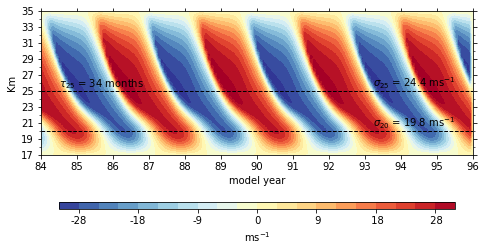

In [10]:
fig_size = (06.90, 02.20+01.50)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

cmin = -np.max(np.abs(u.detach().numpy()))
cmax = np.max(np.abs(u.detach().numpy()))

xmin = 84.
xmax = 96.
ymin = 17.
ymax = 35.

ax[0].set_xlim(left=84.)
ax[0].set_xlim(right=96.)
ax[0].set_ylim(bottom=17.)
ax[0].set_ylim(top=35.)

h = []
    
h.append(ax[0].contourf(solver.time[::30]/86400/360, solver.z[:]/1000, u.detach().numpy()[::30, :].T,
                           21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

ax[0].axhline(25., xmin=0, xmax=1, color='black', linestyle='dashed', linewidth=1.)
ax[0].axhline(20., xmin=0, xmax=1, color='black', linestyle='dashed', linewidth=1.)

ax[0].set_ylabel('Km', fontsize=10)

ax[0].set_xlabel('model year', fontsize=10)

xticks_list = np.arange(xmin, xmax+1, 1)
ax[0].set_xticks(xticks_list)

yticks_list = np.arange(ymin, ymax+2, 2)
ax[0].set_yticks(yticks_list)

xticklabels_list = list(xticks_list)
xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
ax[0].set_xticklabels(xticklabels_list, fontsize=10)

ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
ax[0].tick_params(which='both', labelbottom=True)

ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r' $\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r' $\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %tau25 + ' months',
              horizontalalignment='left', verticalalignment='bottom', color='black')

# # colorbars
cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
                      boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
                      label=r'$\mathrm{m s^{-1}}$')

### Optimizing (takes about 30 min)

In [11]:
solver = adsolver.ADSolver(t_max=360*96*86400)
As = (torch.tensor([4.5e-4, -4.5e-4]) / 0.1006).requires_grad_()
cs = torch.tensor([35., -35.]).requires_grad_()
# u_spunup = solver.solve(source_func=utils.make_source_func(solver, As=As, cs=cs), nsteps=360*12+1)[-1]
# initial_condition = lambda _: u_spunup

optimizer = torch.optim.Adam([As, cs])
max_iters = 3

i_25km = abs(solver.z - 25e3).argmin()
i_20km = abs(solver.z - 20e3).argmin()

target_sigma25 = 23.5
target_sigma20 = 21
target_tau25 = 28

def get_loss(u):
    return ((utils.estimate_amplitude(solver.time, solver.z, u, height=25e3) - target_sigma25) ** 2 / target_sigma25 ** 2 +
            (utils.estimate_amplitude(solver.time, solver.z, u, height=20e3) - target_sigma20) ** 2 / target_sigma20 ** 2 +
            (utils.estimate_period(solver.time, solver.z, u, height=25e3) - target_tau25) ** 2 / target_tau25 ** 2 )

for n_iter in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    u = solver.solve(source_func=utils.make_source_func(solver, As=As, cs=cs))
    
    loss = get_loss(u)
    loss.backward()
    optimizer.step()
    
    if n_iter % 1 == 0:
        print(f'Iteration {n_iter}: loss is {loss:.4f}')

Iteration 1: loss is 0.0487
Iteration 2: loss is 0.0156
Iteration 3: loss is 0.0174


### After optimization

In [12]:
# estimating QBO amplitudes and period
spinup_time = 12*360*86400

amp25 = utils.estimate_amplitude(solver.time, solver.z, u.detach(), height=25e3, spinup=spinup_time)
amp20 = utils.estimate_amplitude(solver.time, solver.z, u.detach(), height=20e3, spinup=spinup_time)
tau25 = utils.estimate_period(solver.time, solver.z, u.detach(), height=25e3, spinup=spinup_time)  # in units of days, assuming sample rate of 1 day -- devide by 30 to get period in months for a 360 day year

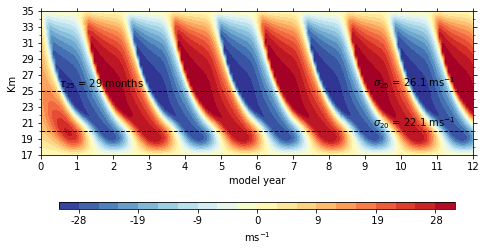

In [13]:
fig_size = (06.90, 02.20+01.50)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

cmin = -np.max(np.abs(u.detach().numpy()))
cmax = np.max(np.abs(u.detach().numpy()))

# xmin = 84.
# xmax = 96.
# ymin = 17.
# ymax = 35.

# ax[0].set_xlim(left=84.)
# ax[0].set_xlim(right=96.)
# ax[0].set_ylim(bottom=17.)
# ax[0].set_ylim(top=35.)

xmin = 0.
xmax = 12.
ymin = 17.
ymax = 35.

ax[0].set_xlim(left=0.)
ax[0].set_xlim(right=12.)
ax[0].set_ylim(bottom=17.)
ax[0].set_ylim(top=35.)

h = []
    
h.append(ax[0].contourf(solver.time[::30]/86400/360, solver.z[:]/1000, u.detach().numpy()[::30, :].T,
                           21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

ax[0].axhline(25., xmin=0, xmax=1, color='black', linestyle='dashed', linewidth=1.)
ax[0].axhline(20., xmin=0, xmax=1, color='black', linestyle='dashed', linewidth=1.)

ax[0].set_ylabel('Km', fontsize=10)

ax[0].set_xlabel('model year', fontsize=10)

xticks_list = np.arange(xmin, xmax+1, 1)
ax[0].set_xticks(xticks_list)

yticks_list = np.arange(ymin, ymax+2, 2)
ax[0].set_yticks(yticks_list)

xticklabels_list = list(xticks_list)
xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
ax[0].set_xticklabels(xticklabels_list, fontsize=10)

ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
ax[0].tick_params(which='both', labelbottom=True)

# ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r' $\mathrm{m s^{-1}}$',
#               horizontalalignment='right', verticalalignment='bottom', color='black')

# ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r' $\mathrm{m s^{-1}}$',
#               horizontalalignment='right', verticalalignment='bottom', color='black')

# ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %tau25 + ' months',
#               horizontalalignment='left', verticalalignment='bottom', color='black')

ax[0].text(11.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r' $\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(11.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r' $\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(00.50, 25, r'$\tau_{25}$ = ' '%.0f' %tau25 + ' months',
              horizontalalignment='left', verticalalignment='bottom', color='black')

# # colorbars
cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
                      boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
                      label=r'$\mathrm{m s^{-1}}$')